<a href="https://colab.research.google.com/github/mlvlab/data303/blob/main/Image_Generation_by_NormalizingFlows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Import required package

In [ ]:
import torch
import torchvision as tv
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

### 1. Define 2D Gaussian base distribution & target

In [ ]:
def zero_log_det_like_z(z):
    return torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)

# Base Distribution
class DiagGaussian(nn.Module):
    # Multivariate Gaussian distribution with diagonal covariance matrix

    def __init__(self, shape, trainable=True):
        super().__init__()
        if isinstance(shape, int):
            shape = (shape,)
        if isinstance(shape, list):
            shape = tuple(shape)
        self.shape = shape
        self.n_dim = len(shape)
        self.d = np.prod(shape)
        if trainable:
            self.loc = nn.Parameter(torch.zeros(1, *self.shape))
            self.log_scale = nn.Parameter(torch.zeros(1, *self.shape))
        else:
            self.register_buffer("loc", torch.zeros(1, *self.shape))
            self.register_buffer("log_scale", torch.zeros(1, *self.shape))
        self.temperature = None  # Temperature parameter for annealed sampling

    def forward(self, num_samples=1, context=None):
        eps = torch.randn(
            (num_samples,) + self.shape, dtype=self.loc.dtype, device=self.loc.device
        )
        if self.temperature is None:
            log_scale = self.log_scale
        else:
            log_scale = self.log_scale + np.log(self.temperature)
        z = self.loc + torch.exp(log_scale) * eps
        log_p = -0.5 * self.d * np.log(2 * np.pi) - torch.sum(
            log_scale + 0.5 * torch.pow(eps, 2), list(range(1, self.n_dim + 1))
        )
        return z, log_p

    def log_prob(self, z, context=None):
        if self.temperature is None:
            log_scale = self.log_scale
        else:
            log_scale = self.log_scale + np.log(self.temperature)
        log_p = -0.5 * self.d * np.log(2 * np.pi) - torch.sum(
            log_scale + 0.5 * torch.pow((z - self.loc) / torch.exp(log_scale), 2),
            list(range(1, self.n_dim + 1)),
        )
        return log_p

    def sample(self, num_samples=1, **kwargs):
        # Samples from base distribution

        z, _ = self.forward(num_samples, **kwargs)
        return z

In [ ]:
class CircularGaussianMixture(nn.Module):
    # 8 gaussian distribution

    def __init__(self, n_modes=8):
        super(CircularGaussianMixture, self).__init__()
        self.n_modes = n_modes
        self.register_buffer(
            "scale", torch.tensor(2 / 3 * np.sin(np.pi / self.n_modes)).float()
        )

    def log_prob(self, z):
        d = torch.zeros((len(z), 0), dtype=z.dtype, device=z.device)
        for i in range(self.n_modes):
            d_ = (
                (z[:, 0] - 2 * np.sin(2 * np.pi / self.n_modes * i)) ** 2
                + (z[:, 1] - 2 * np.cos(2 * np.pi / self.n_modes * i)) ** 2
            ) / (2 * self.scale**2)
            d = torch.cat((d, d_[:, None]), 1)
        log_p = -torch.log(
            2 * np.pi * self.scale**2 * self.n_modes
        ) + torch.logsumexp(-d, 1)
        return log_p

    def sample(self, num_samples=1):
        eps = torch.randn(
            (num_samples, 2), dtype=self.scale.dtype, device=self.scale.device
        )
        phi = (
            2
            * np.pi
            / self.n_modes
            * torch.randint(0, self.n_modes, (num_samples,), device=self.scale.device)
        )
        loc = torch.stack((2 * torch.sin(phi), 2 * torch.cos(phi)), 1).type(eps.dtype)
        return eps * self.scale + loc


### 2. Define RealNVP models

In [ ]:
class Flow(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, z):
        raise NotImplementedError("Forward pass has not been implemented.")

    def inverse(self, z):
        raise NotImplementedError("This flow has no algebraic inverse.")

In [ ]:
# Flow layers to reshape the latent features

class Split(Flow):
    def __init__(self):
        super().__init__()

    def forward(self, z):
        z1, z2 = z.chunk(2, dim=1)
        log_det = 0
        return [z1, z2], log_det

    def inverse(self, z):
        z1, z2 = z
        z = torch.cat([z1, z2], 1)
        log_det = 0
        return z, log_det


"""
 Merge - Same as Split but with forward and backward pass interchanged
"""
class Merge(Split):
    def __init__(self):
        super().__init__()

    def forward(self, z):
        return super().inverse(z)

    def inverse(self, z):
        return super().forward(z)


In [ ]:
class Permute(Flow):
    def __init__(self, num_channels):
        super().__init__()
        self.num_channels = num_channels
        perm = torch.randperm(self.num_channels)
        inv_perm = torch.empty_like(perm).scatter_(
            dim=0, index=perm, src=torch.arange(self.num_channels)
        )
        self.register_buffer("perm", perm)
        self.register_buffer("inv_perm", inv_perm)

    def forward(self, z, context=None):
        z = z[:, self.perm, ...]
        log_det = torch.zeros(len(z), device=z.device)
        return z, log_det

    def inverse(self, z, context=None):
        z = z[:, self.inv_perm, ...]
        log_det = torch.zeros(len(z), device=z.device)
        return z, log_det

In [ ]:
class AffineCoupling(Flow):
    def __init__(self, param_map):
        super().__init__()
        self.add_module("param_map", param_map)

    def forward(self, z):
        z1, z2 = z
        param = self.param_map(z1)
        shift = param[:, 0::2, ...]
        scale_ = param[:, 1::2, ...]
        z2 = z2 * torch.exp(scale_) + shift
        log_det = torch.sum(scale_, dim=list(range(1, shift.dim())))

        return [z1, z2], log_det

    def inverse(self, z):
        z1, z2 = z
        param = self.param_map(z1)
        shift = param[:, 0::2, ...]
        scale_ = param[:, 1::2, ...]
        z2 = (z2 - shift) * torch.exp(-scale_)
        log_det = -torch.sum(scale_, dim=list(range(1, shift.dim())))

        return [z1, z2], log_det


In [ ]:
"""
  Affine Coupling layer including split and merge operation
"""

class AffineCouplingBlock(Flow):
    def __init__(self, param_map):
        super().__init__()
        self.flows = nn.ModuleList([])
        # Split layer
        self.flows += [Split()]
        # Affine coupling layer
        self.flows += [AffineCoupling(param_map)]
        # Merge layer
        self.flows += [Merge()]

    def forward(self, z):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_tot += log_det

        return z, log_det_tot

    def inverse(self, z):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_det_tot += log_det

        return z, log_det_tot


In [ ]:
class NormalizingFlow(nn.Module):

    def __init__(self, q0, flows, p=None):
        super().__init__()
        self.q0 = q0 # Base distribution
        self.flows = nn.ModuleList(flows) # list of flows
        self.p = p # Target distribution

    def forward(self, z):

        for flow in self.flows:
            z, _ = flow(z)
        return z

    def forward_and_log_det(self, z):

        log_det = torch.zeros(len(z), device=z.device)
        for flow in self.flows:
            z, log_d = flow(z)
            log_det += log_d
        return z, log_det

    def inverse(self, x):

        for i in range(len(self.flows) - 1, -1, -1):
            x, _ = self.flows[i].inverse(x)
        return x

    def inverse_and_log_det(self, x):

        log_det = torch.zeros(len(x), device=x.device)
        for i in range(len(self.flows) - 1, -1, -1):
            x, log_d = self.flows[i].inverse(x)
            log_det += log_d
        return x, log_det

    def forward_kld(self, x):
        # Estimates forward KL divergence

        log_q = torch.zeros(len(x), device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return -torch.mean(log_q)

    def reverse_kld(self, num_samples=1, beta=1.0, score_fn=True):
        # Estimates reverse KL divergence

        z, log_q_ = self.q0(num_samples)
        log_q = torch.zeros_like(log_q_)
        log_q += log_q_
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        if not score_fn:
            z_ = z
            log_q = torch.zeros(len(z_), device=z_.device)

            for param in self.parameters():
              param.requires_grad = False

            for i in range(len(self.flows) - 1, -1, -1):
                z_, log_det = self.flows[i].inverse(z_)
                log_q += log_det
            log_q += self.q0.log_prob(z_)

            for param in self.parameters():
              param.requires_grad = True

        log_p = self.p.log_prob(z)
        return torch.mean(log_q) - beta * torch.mean(log_p)

    def sample(self, num_samples=1):
        """
        Samples from flow-based approximate distribution
        """
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q

    def log_prob(self, x):

        log_q = torch.zeros(len(x), dtype=x.dtype, device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return log_q

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))

In [ ]:
class ConstScaleLayer(nn.Module):
    def __init__(self, scale=1.0):

        super().__init__()
        self.scale_cpu = torch.tensor(scale)
        self.register_buffer("scale", self.scale_cpu)

    def forward(self, input):
        return input * self.scale

class ClampExp(nn.Module):
    """
    Nonlinearity min(exp(lam * x), 1)
    """

    def __init__(self):
        super(ClampExp, self).__init__()

    def forward(self, x):
        one = torch.tensor(1.0, device=x.device, dtype=x.dtype)
        return torch.min(torch.exp(x), one)


class MLP(nn.Module):

    def __init__(
        self,
        layers,
        leaky=0.0,
        score_scale=None,
        output_fn=None,
        output_scale=None,
        init_zeros=False,
        dropout=None,
    ):

        super().__init__()
        net = nn.ModuleList([])
        for k in range(len(layers) - 2):
            net.append(nn.Linear(layers[k], layers[k + 1]))
            net.append(nn.LeakyReLU(leaky))
        if dropout is not None:
            net.append(nn.Dropout(p=dropout))
        net.append(nn.Linear(layers[-2], layers[-1]))
        if init_zeros:
            nn.init.zeros_(net[-1].weight)
            nn.init.zeros_(net[-1].bias)
        if output_fn is not None:
            if score_scale is not None:
                net.append(ConstScaleLayer(score_scale))
            if output_fn == "sigmoid":
                net.append(nn.Sigmoid())
            elif output_fn == "relu":
                net.append(nn.ReLU())
            elif output_fn == "tanh":
                net.append(nn.Tanh())
            elif output_fn == "clampexp":
                net.append(ClampExp())
            else:
                NotImplementedError("This output function is not implemented.")
            if output_scale is not None:
                net.append(ConstScaleLayer(output_scale))
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

### 3. Set up RealNVP for 2D toy Experiments

In [ ]:
# Define 2D Gaussian base distribution & target distribution

base = DiagGaussian(2)
target = CircularGaussianMixture()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


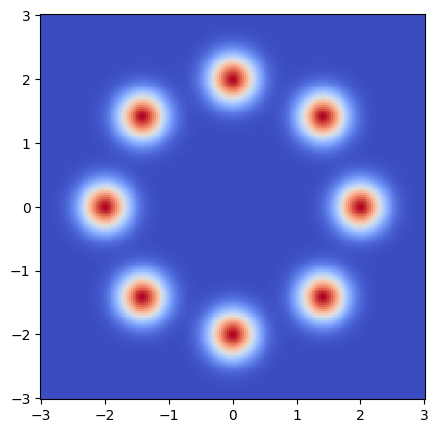

In [ ]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(5, 5))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

In [ ]:
# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(Permute(2))

# Construct flow model
model = NormalizingFlow(base, flows)
model = model.to(device)

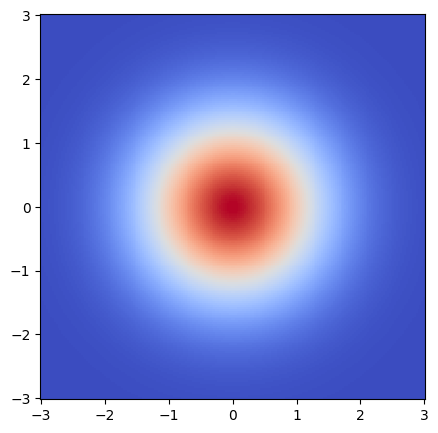

In [ ]:
# Plot initial flow distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(5, 5))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

### 4. Train RealNVP

 12%|█▏        | 499/4000 [00:30<04:05, 14.29it/s]

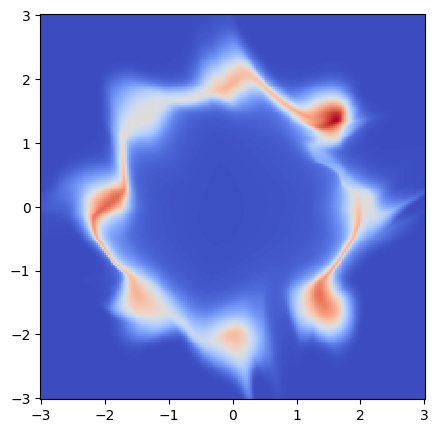

 25%|██▍       | 998/4000 [00:57<02:30, 19.92it/s]

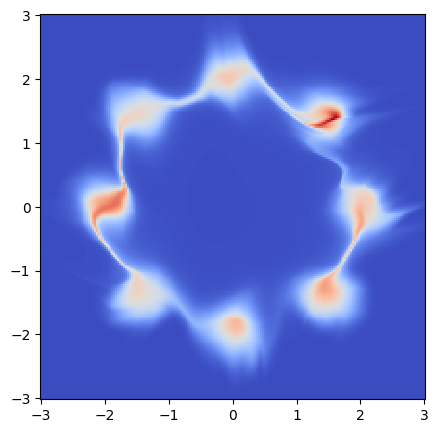

 37%|███▋      | 1499/4000 [01:26<02:04, 20.10it/s]

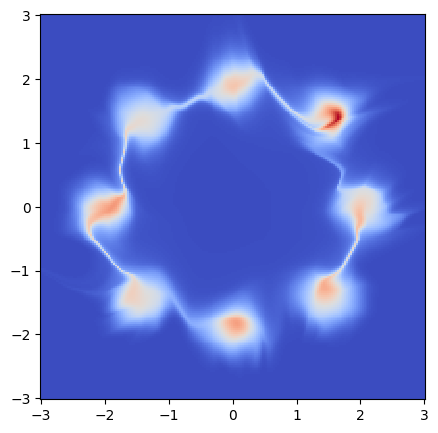

 50%|████▉     | 1998/4000 [01:54<02:12, 15.11it/s]

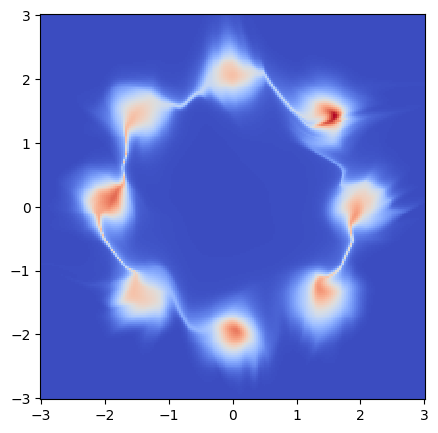

 62%|██████▏   | 2498/4000 [02:22<01:19, 18.92it/s]

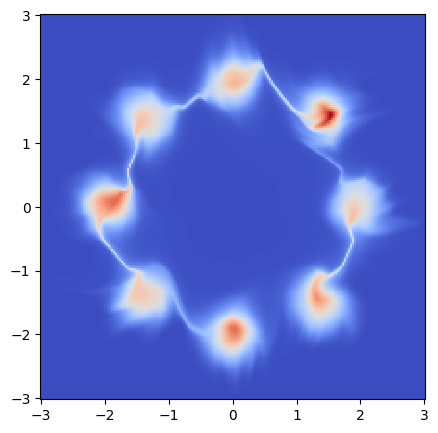

 75%|███████▍  | 2998/4000 [02:49<00:51, 19.28it/s]

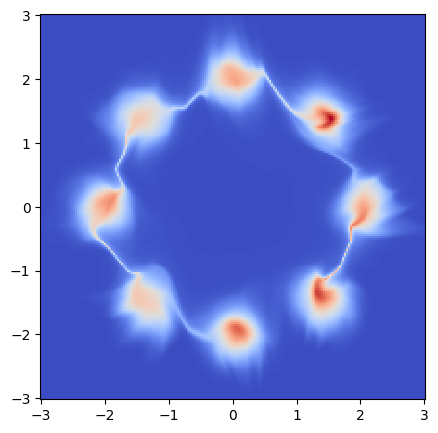

 87%|████████▋ | 3498/4000 [03:16<00:26, 19.10it/s]

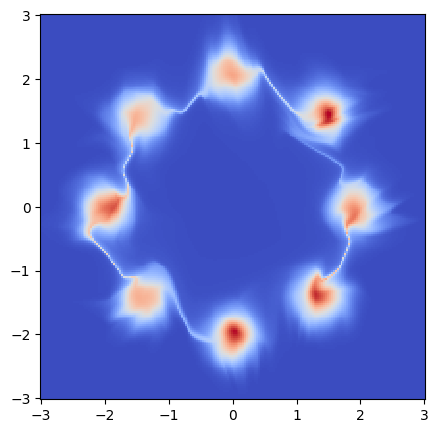

100%|█████████▉| 3999/4000 [03:44<00:00, 17.73it/s]

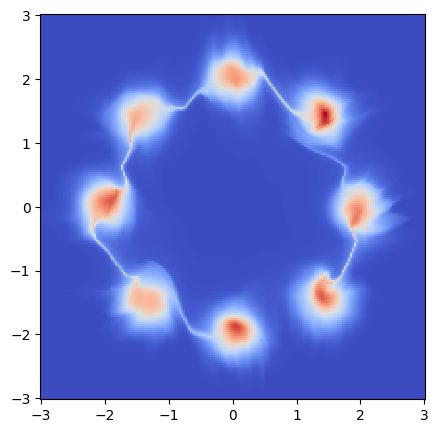

100%|██████████| 4000/4000 [03:45<00:00, 17.76it/s]


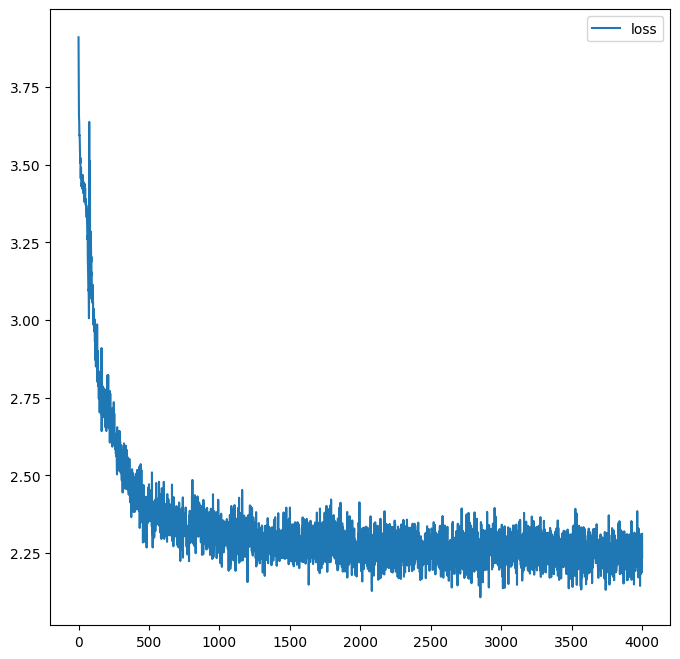

In [ ]:
max_iter = 4000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # Get training samples
    x = target.sample(num_samples).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(5, 5))
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(8, 8))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

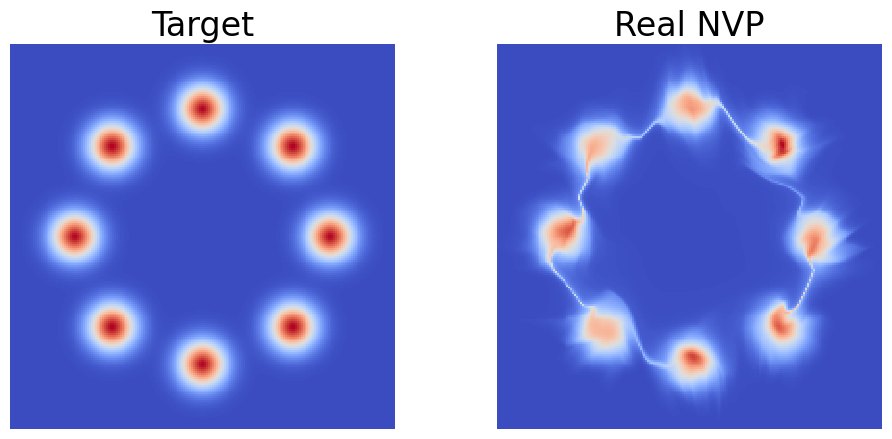

In [ ]:
# Plot target distribution
f, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[0].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[0].set_aspect('equal', 'box')
ax[0].set_axis_off()
ax[0].set_title('Target', fontsize=24)

# Plot learned distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[1].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[1].set_aspect('equal', 'box')
ax[1].set_axis_off()
ax[1].set_title('Real NVP', fontsize=24)

plt.subplots_adjust(wspace=0.1)

plt.show()

### 5. Training for MNIST datasets

5-1. Prepares MNIST datasets

In [ ]:
# Prepare training data
batch_size = 128

transform = tv.transforms.Compose([tv.transforms.ToTensor(),
                                   tv.transforms.Normalize((0.5), (1.0))])

class_label = [1,2,3] # Or Set it as you want [1], [4], [1, 9], ... digit 0~9
train_dataset = tv.datasets.MNIST('datasets/', train=True, download=True, transform=transform)
class_one_indices = [i for i, (_, label) in enumerate(train_dataset) if label in class_label]
class_one_dataset_train = torch.utils.data.Subset(train_dataset, class_one_indices)

train_loader = torch.utils.data.DataLoader(class_one_dataset_train,  batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = tv.datasets.MNIST('datasets/', train=False, download=True, transform=transform)
class_one_indices = [i for i, (_, label) in enumerate(test_dataset) if label == class_label]
class_one_dataset_test = torch.utils.data.Subset(test_dataset, class_one_indices)
test_loader = torch.utils.data.DataLoader(class_one_dataset_test, batch_size=batch_size)

train_iter = iter(train_loader)

100%|██████████| 9912422/9912422 [00:00<00:00, 116527120.28it/s]


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27178751.14it/s]


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32054522.26it/s]


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18300219.76it/s]


Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



** 5-2. Define your own NF model - Quiz
* Write down answer1~4 and Train you model on MNIST datasets

In [ ]:
# Define Gaussian base distribution
# answer1 = ?
# answer2 = ?
# answer3 = ?
# answer4 = ?

mnist_base = DiagGaussian(answer1)

# Define list of flows
num_layers = 32 # Or Set it as you want (integer) 8, 12, 16, 32, ...
flows = []
for i in range(num_layers):
    param_map = MLP([answer2, 64, 64, answer3], init_zeros=True)
    # Add flow layer
    flows.append(AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(Permute(answer4))

# Construct flow model
my_model = NormalizingFlow(mnist_base, flows)
my_model = my_model.to(device)

In [ ]:
# Train model
max_iter = 10000

my_model.train()
optimizer = torch.optim.Adam(my_model.parameters(), lr=5e-4, weight_decay=1e-5)

loss_hist = np.array([])

for i in tqdm(range(max_iter)):
    try:
        x, y = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        x, y = next(train_iter)

    optimizer.zero_grad()
    loss = my_model.forward_kld(x.reshape(batch_size, -1).to(device))

    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

In [ ]:
# Plot loss
plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [ ]:
# Model samples
num_sample = 15
z_sample, _ = my_model.sample(num_sample)
z_sample = z_sample.reshape(num_sample, 28, 28).unsqueeze(1)
z_sample = torch.clamp(z_sample, 0., 1.)
plt.figure(figsize=(5, 15))
plt.imshow(np.transpose(tv.utils.make_grid(z_sample, nrow=3).cpu().numpy(), (1, 2, 0)))
plt.show()